In [4]:
import pandas as pd
import numpy as np
import re
import regex
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from underthesea import word_tokenize, sent_tokenize, pos_tag
from imblearn.over_sampling import SMOTE
from sklearn.metrics import silhouette_score

In [5]:
# Bước 1: Load dữ liệu
# Load data
df = pd.read_excel("reviews.xlsx")
df = df.dropna(subset=["Title", "What I liked", "Suggestions for improvement"])
df['positive_text'] = df['What I liked']
df['negative_text'] = df['Suggestions for improvement']
df['sentiment'] = df['Rating'].apply(lambda x: 'negative' if x <= 2 else 'positive' if x >= 4 else 'neutral')

df.head()

,id,Company Name,Cmt_day,Title,What I liked,Suggestions for improvement,Rating,Salary & benefits,Training & learning,Management cares about me,Culture & fun,Office & workspace,Recommend?,positive_text,negative_text,sentiment
0,4,Accenture,March 2025,"Môi trường thoải mái, ít áp lực, có thể làm vi...","Môi trường thoải mái, ít áp lực, có thể làm vi...",Cần đánh giá KPI khách quan và phân chia công ...,4,4,4,4,4,4,Yes,"Môi trường thoải mái, ít áp lực, có thể làm vi...",Cần đánh giá KPI khách quan và phân chia công ...,positive
1,4,Accenture,January 2025,Công ty trẻ trung năng động,"Cơ sở vật chất đẹp, công ty trẻ trung năng độn...",Nên nghiên cứu lại range lương của thì trường....,4,3,4,4,4,5,Yes,"Cơ sở vật chất đẹp, công ty trẻ trung năng độn...",Nên nghiên cứu lại range lương của thì trường....,positive
2,4,Accenture,October 2023,Môi trường làm việc thoải mái vui vẻ,"Mội người thân thiện, giúp đỡ lẫn nhau. Chương...",Do công ty làm outsourcing về mảng system nên ...,3,3,3,3,3,3,Yes,"Mội người thân thiện, giúp đỡ lẫn nhau. Chương...",Do công ty làm outsourcing về mảng system nên ...,neutral
3,4,Accenture,February 2025,good environment for fresher,good env. for fresher to learn and improve the...,Need to forcus more on benefit and evaluate co...,3,2,2,3,4,4,No,good env. for fresher to learn and improve the...,Need to forcus more on benefit and evaluate co...,neutral
4,4,Accenture,February 2023,"Môi trường làm việc thoải mái, vui vẻ","- Văn phòng đẹp, cơ sở vật chất tốt\n- Sếp và ...",- Phát triển văn phòng để rộng rãi hơn\n- Công...,4,3,4,4,4,3,Yes,"- Văn phòng đẹp, cơ sở vật chất tốt\n- Sếp và ...",- Phát triển văn phòng để rộng rãi hơn\n- Công...,positive


In [6]:
##LOAD EMOJICON
file = open('files/emojicon.txt', 'r', encoding="utf8")
emoji_lst = file.read().split('\n')
emoji_dict = {}
for line in emoji_lst:
    key, value = line.split('\t')
    emoji_dict[key] = str(value)
#print(teen_dict)
file.close()
#################
#LOAD TEENCODE
file = open('files/teencode.txt', 'r', encoding="utf8")
teen_lst = file.read().split('\n')
teen_dict = {}
for line in teen_lst:
    key, value = line.split('\t')
    teen_dict[key] = str(value)
#print(teen_dict)
file.close()
###############
#LOAD TRANSLATE ENGLISH -> VNMESE
file = open('files/english-vnmese.txt', 'r', encoding="utf8")
englist_lst = file.read().split('\n')
for line in englist_lst:
    key, value = line.split('\t')
    teen_dict[key] = str(value)
#print(teen_dict)
file.close()
################
#LOAD wrong words
file = open('files/wrong-word.txt', 'r', encoding="utf8")
wrong_lst = file.read().split('\n')
file.close()
#################
#LOAD STOPWORDS
file = open('files/vietnamese-stopwords.txt', 'r', encoding="utf8")
stopwords_lst = file.read().split('\n')
file.close()

In [7]:
def process_text(text, dict_emoji, dict_teen, dict_eng_vn, lst_wrong):
    document = text.lower()
    document = document.replace("’",'')
    document = regex.sub(r'\.+', ".", document)
    document = re.sub(r'(.)\1+', r'\1', text) # thay thế lònggggg --> lòng
    new_sentence =''
    for sentence in sent_tokenize(document):
        # if not(sentence.isascii()):
        ###### CONVERT EMOJICON
        sentence = ''.join(dict_emoji[word]+' ' if word in dict_emoji else word for word in list(sentence))
        ###### CONVERT TEENCODE
        sentence = ' '.join(dict_teen[word] if word in dict_teen else word for word in sentence.split())
        ###### CONVERT ENGLISH TO VIETNAMESE
        sentence = ' '.join(dict_eng_vn[word] if word in dict_eng_vn else word for word in sentence.split())
        ###### DEL Punctuation & Numbers
        pattern = r'(?i)\b[a-záàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ]+\b'
        sentence = ' '.join(regex.findall(pattern,sentence))
        ###### DEL wrong words
        sentence = ' '.join('' if word in lst_wrong else word for word in sentence.split())
        new_sentence = new_sentence+ sentence + '. '
    document = new_sentence
    #print(document)
     ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    return document

In [8]:
def loaddicchar():
    uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
    unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"

    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic

# Đưa toàn bộ dữ liệu qua hàm này để chuẩn hóa lại
def covert_unicode(txt):
    dicchar = loaddicchar()
    return regex.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

In [9]:
def process_special_word(text):
    new_text = ''
    text_lst = text.split()
    i= 0
    if 'không' in text_lst:
        while i <= len(text_lst) - 1:
            word = text_lst[i]
            #print(word)
            #print(i)
            if  word == 'không':
                next_idx = i+1
                if next_idx <= len(text_lst) -1:
                    word = word +'_'+ text_lst[next_idx]
                i= next_idx + 1
            else:
                i = i+1
            new_text = new_text + word + ' '
    else:
        new_text = text
    return new_text.strip()

In [10]:
def process_postag_thesea(text):
    new_document = ''
    for sentence in sent_tokenize(text):
        sentence = sentence.replace('.','')
        ###### POS tag
        lst_word_type = ['A','AB','V','VB','VY','R']
        sentence = ' '.join( word[0] if word[1].upper() in lst_word_type else '' for word in pos_tag(process_special_word(word_tokenize(sentence, format="text"))))
        new_document = new_document + sentence + ' '
    ###### DEL excess blank space
    new_document = regex.sub(r'\s+', ' ', new_document).strip()
    return new_document

In [11]:
def remove_stopword(text, stopwords):
    ###### REMOVE stop words
    document = ' '.join('' if word in stopwords else word for word in text.split())
    #print(document)
    ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    return document

In [12]:
# Apply preprocessing
df['positive_clean'] = df['positive_text'].apply(lambda x: process_text(str(x), emoji_dict, englist_lst, teen_dict,wrong_lst)) \
                                       .apply(covert_unicode) \
                                       .apply(process_special_word) \
                                       .apply(lambda x: remove_stopword(str(x), stopwords_lst)) \
                                       .apply(process_postag_thesea)
df['negative_clean'] = df['negative_text'].apply(lambda x: process_text(str(x), emoji_dict,englist_lst, teen_dict, wrong_lst)) \
                                       .apply(covert_unicode) \
                                       .apply(process_special_word) \
                                       .apply(lambda x: remove_stopword(str(x), stopwords_lst)) \
                                       .apply(process_postag_thesea)

In [13]:
df['positive_clean']

0       thoải_mái hybrid thỏa_thuận tốt đủ dịch_vụ cải...
1                               đẹp trẻ kết_hợp dự_án thể
2       thân_thiện lẫn chuyên_nghiệp tổ_chức Khá yêu_c...
3                                    ability opened teams
4       đẹp vật_chất tốt đồng_nghiệp Đồng_nghiệp vẻ th...
                              ...                        
8412    ấn_tượng vấn fedback Macbok bàn_phím dự_án tra...
8413    thoải_mái kiến chuyên_nghiệp mới nhân_viên độ ...
8414    interview thân_thiện constructive rounds equip...
8415    open organization recruitment fedback thư_giãn...
8416    keyboard mặc dùng vấn_cực tiếp_tục tiếp luôn c...
Name: positive_clean, Length: 8411, dtype: object

In [14]:
df['negative_clean']

0                         Cần phân_chuyên_nghiệp khả_năng
1                                            range maping
2                            outsourcing_mảng system_nghệ
3                                         forcus evaluate
4                                               văn_phòng
                              ...                        
8412               vô Việt_Nam khóa học ít reily platform
8413                              hình_thể đóng_góp trình
8414                suốt tất_thể develop_bonding if_thông
8415    stil joiners clas_outdor không_hơn đổi đào âm_...
8416                                   Công cải_thiện hơn
Name: negative_clean, Length: 8411, dtype: object

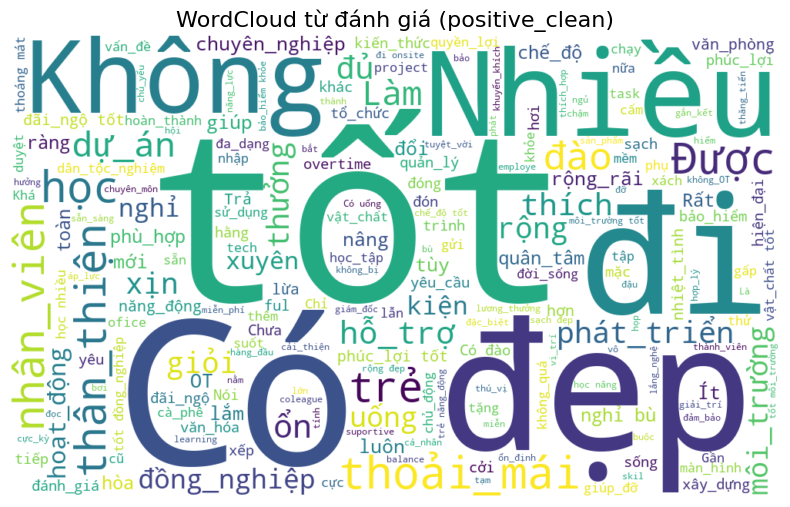

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Ghép toàn bộ văn bản trong cột "clean_text" thành một chuỗi
text = " ".join(df["positive_clean"].dropna().astype(str).tolist())

wordcloud = WordCloud(
    width=1000,
    height=600,
    background_color="white"
).generate(text)

# Hiển thị WordCloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud từ đánh giá (positive_clean)", fontsize=16)
plt.show()

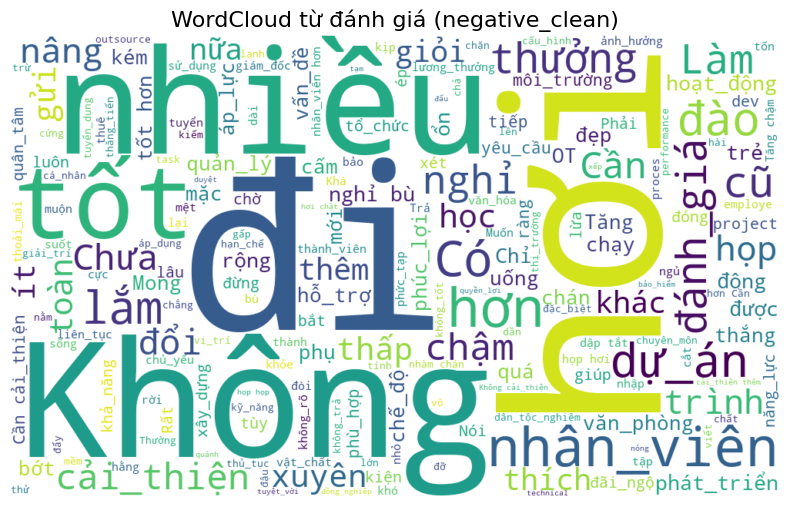

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Ghép toàn bộ văn bản trong cột "clean_text" thành một chuỗi
text = " ".join(df["negative_clean"].dropna().astype(str).tolist())

wordcloud = WordCloud(
    width=1000,
    height=600,
    background_color="white"
).generate(text)

# Hiển thị WordCloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud từ đánh giá (negative_clean)", fontsize=16)
plt.show()

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

# Vectorization
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2))
positive_matrix = vectorizer.fit_transform(df['positive_clean'])
negative_matrix = vectorizer.transform(df['negative_clean'])

In [18]:
# LDA for positive and negative feedback
n_topics_positive = 4

lda_positive = LatentDirichletAllocation(n_components=n_topics_positive, random_state=42)

lda_positive_matrix = lda_positive.fit_transform(positive_matrix)


In [19]:
lda_positive_matrix[:5]

array([[0.79608076, 0.07024451, 0.06698905, 0.06668568],
       [0.20212305, 0.31780979, 0.41068408, 0.06938309],
       [0.7956119 , 0.06498275, 0.0694104 , 0.06999494],
       [0.10389677, 0.68872744, 0.10369234, 0.10368344],
       [0.06486537, 0.53600432, 0.33697856, 0.06215175]])

### Positive comment

In [20]:
from scipy.spatial.distance import cdist
distortions = []
K = range(1, 8)
for k in K:
    kmeansmodel = KMeans(n_clusters=k)
    kmeansmodel.fit(lda_positive_matrix)
    distortions.append(kmeansmodel.inertia_)

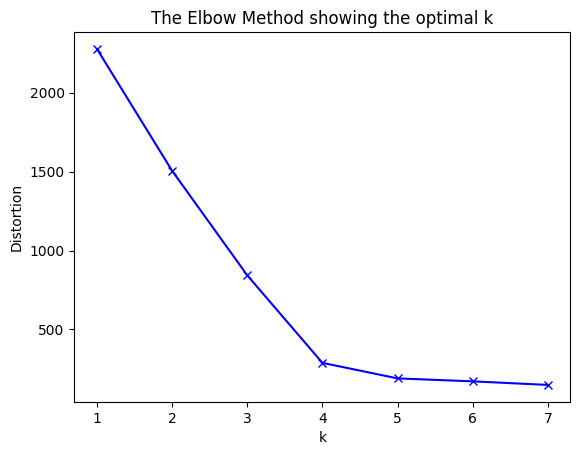

In [21]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Chon k =4

In [22]:
# Bước 5: Phân cụm bằng KMeans trên vector chủ đề
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df["cluster"] = kmeans.fit_predict(lda_positive_matrix)

In [23]:
# count samples per cluster
df["cluster"].value_counts()

cluster
0    2407
2    2227
1    2091
3    1686
Name: count, dtype: int64

In [24]:
from sklearn.decomposition import PCA

# Bước 6: Giảm chiều bằng PCA để trực quan
pca_positive = PCA(n_components=2)
coords_positive = pca_positive.fit_transform(lda_positive_matrix)
df["x"] = coords_positive[:, 0]
df["y"] = coords_positive[:, 1]

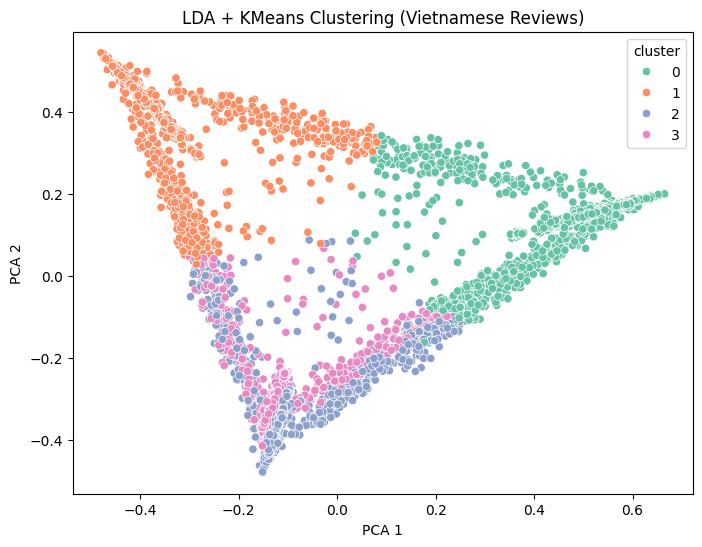

In [25]:
# Bước 7: Vẽ biểu đồ cụm
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="x", y="y", hue="cluster", palette="Set2")
plt.title("LDA + KMeans Clustering (Vietnamese Reviews)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

In [26]:
# Bước 8: Hiển thị từ khóa đặc trưng mỗi topic
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_positive.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    print(f"Chủ đề #{topic_idx + 1}: {', '.join(top_words)}")

Chủ đề #1: tốt, có, học, đẹp, nhân_viên, đào, thân_thiện, nhiều, trẻ, nghỉ
Chủ đề #2: đẹp, thoải_mái, đi, overtime, tốt, văn_phòng, dự_án, vật_chất, nhiều, đào
Chủ đề #3: đi, nhiều, được, tốt, có, làm, dự_án, không, trẻ, học
Chủ đề #4: tốt, không, thân_thiện, môi_trường, rộng, trẻ, đồng_nghiệp, đẹp, rộng_rãi, đãi_ngộ


### Negative Comment

In [27]:
n_topics_negative = 3

lda_negative = LatentDirichletAllocation(n_components=n_topics_negative, random_state=42)

lda_negative_matrix = lda_negative.fit_transform(negative_matrix)

In [28]:
lda_negative_matrix[:5]

array([[0.13818836, 0.34540484, 0.5164068 ],
       [0.66636588, 0.16683965, 0.16679447],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.16670884, 0.65875869, 0.17453247]])

In [29]:
from scipy.spatial.distance import cdist
distortions = []
K = range(1, 8)
for k in K:
    kmeansmodel = KMeans(n_clusters=k)
    kmeansmodel.fit(lda_negative_matrix)
    distortions.append(kmeansmodel.inertia_)

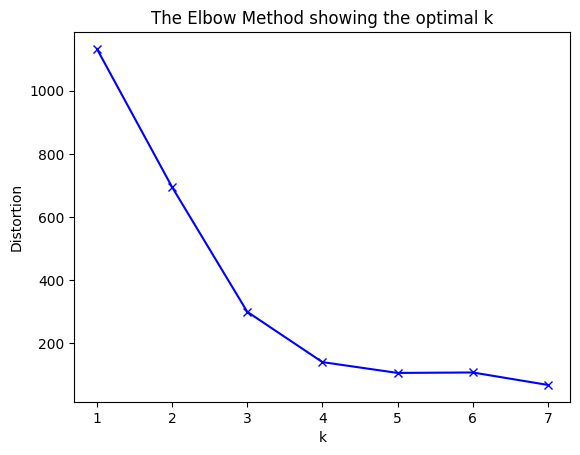

In [30]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Chon k=3

In [31]:
# Bước 5: Phân cụm bằng KMeans trên vector chủ đề
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df["cluster"] = kmeans.fit_predict(lda_negative_matrix)

In [32]:
# count samples per cluster
df["cluster"].value_counts()

cluster
1    2667
0    2295
2    1821
3    1628
Name: count, dtype: int64

In [33]:
from sklearn.decomposition import PCA

# Bước 6: Giảm chiều bằng PCA để trực quan
pca_negative = PCA(n_components=2)
coords_negative = pca_negative.fit_transform(lda_negative_matrix)
df["x"] = coords_negative[:, 0]
df["y"] = coords_negative[:, 1]

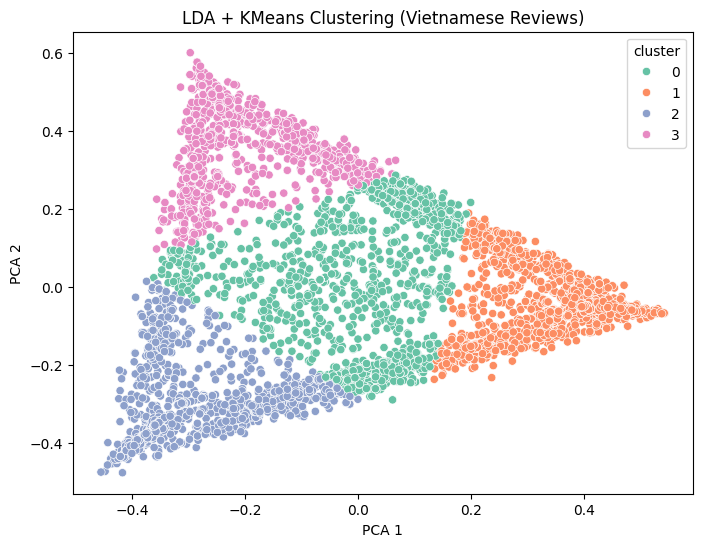

In [34]:
# Bước 7: Vẽ biểu đồ cụm
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="x", y="y", hue="cluster", palette="Set2")
plt.title("LDA + KMeans Clustering (Vietnamese Reviews)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

In [35]:
# Bước 8: Hiển thị từ khóa đặc trưng mỗi topic
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_negative.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    print(f"Chủ đề #{topic_idx + 1}: {', '.join(top_words)}")

Chủ đề #1: tốt, nhân_viên, nghỉ, thưởng, chưa, có, gửi, đào, mong, làm
Chủ đề #2: họp, chậm, đi, cũ, đánh_giá, tăng, ít, chán, quá, cấm
Chủ đề #3: hơi, hơn, cần, cải_thiện, nhiều, lắm, không, thêm, thấp, dự_án


## EVALUATE

In [36]:
def analyze_cluster_topic_distribution(df, lda_matrix, comment_type="Positive"):
    # Group by cluster and get mean topic distribution
    cluster_topic_dist = pd.DataFrame(lda_matrix).groupby(df['cluster']).mean()
    
    print(f"\n{comment_type.upper()} COMMENTS CLUSTER ANALYSIS")
    print("-" * 50)
    
    # For each cluster
    for cluster_id in range(len(cluster_topic_dist)):
        print(f"\nCluster {cluster_id+1}:")
        
        # Get topic distribution for this cluster
        topic_dist = cluster_topic_dist.iloc[cluster_id]
        
        # Sort topics by strength
        sorted_topics = sorted(enumerate(topic_dist), key=lambda x: x[1], reverse=True)
        
        # Print topic distribution
        print("Topic Distribution:")
        for topic_idx, strength in sorted_topics:
            print(f"Topic {topic_idx + 1}: {strength:.3f}")
        
        # Show cluster size
        cluster_size = (df['cluster'] == cluster_id).sum()
        print(f"Cluster size: {cluster_size} documents ({cluster_size/len(df)*100:.1f}%)")

print("\n" + "="*80)
print("ANALYZING TOPIC DOMINANCE IN CLUSTERS")
print("="*80)

# For positive comments (3 clusters)
kmeans_positive = KMeans(n_clusters=4, random_state=42)
df["cluster"] = kmeans_positive.fit_predict(lda_positive_matrix)
analyze_cluster_topic_distribution(df, lda_positive_matrix, "Positive")

# For negative comments (2 clusters)
kmeans_negative = KMeans(n_clusters=3, random_state=42)
df["cluster"] = kmeans_negative.fit_predict(lda_negative_matrix)
analyze_cluster_topic_distribution(df, lda_negative_matrix, "Negative")


ANALYZING TOPIC DOMINANCE IN CLUSTERS

POSITIVE COMMENTS CLUSTER ANALYSIS
--------------------------------------------------

Cluster 1:
Topic Distribution:
Topic 1: 0.351
Topic 4: 0.233
Topic 3: 0.212
Topic 2: 0.204
Cluster size: 2407 documents (28.6%)

Cluster 2:
Topic Distribution:
Topic 4: 0.325
Topic 1: 0.265
Topic 2: 0.206
Topic 3: 0.205
Cluster size: 2091 documents (24.9%)

Cluster 3:
Topic Distribution:
Topic 2: 0.311
Topic 1: 0.251
Topic 4: 0.226
Topic 3: 0.212
Cluster size: 2227 documents (26.5%)

Cluster 4:
Topic Distribution:
Topic 3: 0.296
Topic 1: 0.259
Topic 4: 0.236
Topic 2: 0.209
Cluster size: 1686 documents (20.0%)

NEGATIVE COMMENTS CLUSTER ANALYSIS
--------------------------------------------------

Cluster 1:
Topic Distribution:
Topic 3: 0.368
Topic 2: 0.332
Topic 1: 0.300
Cluster size: 3351 documents (39.8%)

Cluster 2:
Topic Distribution:
Topic 3: 0.431
Topic 1: 0.291
Topic 2: 0.278
Cluster size: 2984 documents (35.5%)

Cluster 3:
Topic Distribution:
Topic 3: 0.

In [37]:
# Group by company and cluster, count positive and negative reviews
summary = df.groupby(['Company Name', 'cluster', 'sentiment']).size().unstack(fill_value=0)

# Determine if feedback is mostly positive or negative in each cluster for each company
summary['category'] = summary.apply(
    lambda row: 'positive' if row.get('positive', 0) > row.get('negative', 0) else 'negative', axis=1
)

# For each company, list clusters with mostly positive and mostly negative feedback
result = summary.reset_index().groupby('Company Name').agg({
    'cluster': list,
    'category': list
})

for company, row in result.iterrows():
    positive_clusters = [c for c, cat in zip(row['cluster'], row['category']) if cat == 'positive']
    negative_clusters = [c for c, cat in zip(row['cluster'], row['category']) if cat == 'negative']
    print(f"Company: {company}")
    print(f"  Positive feedback in clusters: {positive_clusters}")
    print(f"  Negative feedback in clusters: {negative_clusters}\n")

Company: ANDPAD VietNam Co., Ltd
  Positive feedback in clusters: [0, 1, 2]
  Negative feedback in clusters: []

Company: ARIS Vietnam
  Positive feedback in clusters: [0, 1]
  Negative feedback in clusters: [2]

Company: AZPLAYS Co., LTD
  Positive feedback in clusters: [0, 1, 2]
  Negative feedback in clusters: []

Company: AZoom VietNam
  Positive feedback in clusters: [0, 1]
  Negative feedback in clusters: []

Company: Accenture
  Positive feedback in clusters: [0, 1]
  Negative feedback in clusters: [2]

Company: Adnovum Vietnam
  Positive feedback in clusters: [0, 1, 2]
  Negative feedback in clusters: []

Company: Ahamove
  Positive feedback in clusters: [1, 2]
  Negative feedback in clusters: [0]

Company: Allexceed Việt Nam
  Positive feedback in clusters: [0, 1, 2]
  Negative feedback in clusters: []

Company: Alpaca Vietnam
  Positive feedback in clusters: [0, 1]
  Negative feedback in clusters: []

Company: Asilla
  Positive feedback in clusters: [0, 1, 2]
  Negative feedb

In [38]:
df.head()

,id,Company Name,Cmt_day,Title,What I liked,Suggestions for improvement,Rating,Salary & benefits,Training & learning,Management cares about me,...,Office & workspace,Recommend?,positive_text,negative_text,sentiment,positive_clean,negative_clean,cluster,x,y
0,4,Accenture,March 2025,"Môi trường thoải mái, ít áp lực, có thể làm vi...","Môi trường thoải mái, ít áp lực, có thể làm vi...",Cần đánh giá KPI khách quan và phân chia công ...,4,4,4,4,...,4,Yes,"Môi trường thoải mái, ít áp lực, có thể làm vi...",Cần đánh giá KPI khách quan và phân chia công ...,positive,thoải_mái hybrid thỏa_thuận tốt đủ dịch_vụ cải...,Cần phân_chuyên_nghiệp khả_năng,1,0.175233,0.132742
1,4,Accenture,January 2025,Công ty trẻ trung năng động,"Cơ sở vật chất đẹp, công ty trẻ trung năng độn...",Nên nghiên cứu lại range lương của thì trường....,4,3,4,4,...,5,Yes,"Cơ sở vật chất đẹp, công ty trẻ trung năng độn...",Nên nghiên cứu lại range lương của thì trường....,positive,đẹp trẻ kết_hợp dự_án thể,range maping,2,-0.318469,-0.302394
2,4,Accenture,October 2023,Môi trường làm việc thoải mái vui vẻ,"Mội người thân thiện, giúp đỡ lẫn nhau. Chương...",Do công ty làm outsourcing về mảng system nên ...,3,3,3,3,...,3,Yes,"Mội người thân thiện, giúp đỡ lẫn nhau. Chương...",Do công ty làm outsourcing về mảng system nên ...,neutral,thân_thiện lẫn chuyên_nghiệp tổ_chức Khá yêu_c...,outsourcing_mảng system_nghệ,0,-0.067230,0.018923
3,4,Accenture,February 2025,good environment for fresher,good env. for fresher to learn and improve the...,Need to forcus more on benefit and evaluate co...,3,2,2,3,...,4,No,good env. for fresher to learn and improve the...,Need to forcus more on benefit and evaluate co...,neutral,ability opened teams,forcus evaluate,0,-0.067230,0.018923
4,4,Accenture,February 2023,"Môi trường làm việc thoải mái, vui vẻ","- Văn phòng đẹp, cơ sở vật chất tốt\n- Sếp và ...",- Phát triển văn phòng để rộng rãi hơn\n- Công...,4,3,4,4,...,3,Yes,"- Văn phòng đẹp, cơ sở vật chất tốt\n- Sếp và ...",- Phát triển văn phòng để rộng rãi hơn\n- Công...,positive,đẹp vật_chất tốt đồng_nghiệp Đồng_nghiệp vẻ th...,văn_phòng,0,-0.211291,0.390581


In [39]:
def assign_cluster_topics(lda_matrix, feature_names, n_words=10):
    """Create a mapping of cluster to their dominant topics and keywords"""
    cluster_topics = {}
    
    for topic_idx, topic in enumerate(lda_matrix.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_words-1:-1]]
        cluster_topics[topic_idx] = {
            'keywords': top_words,
            'description': ', '.join(top_words[:5])  
        }
    
    return cluster_topics

def analyze_company_feedback(df):
    # Display available companies
    print("Available companies:")
    companies = df['Company Name'].unique()
    for idx, company in enumerate(companies, 1):
        print(f"{idx}. {company}")
    
    while True:
        company_input = input("\nEnter company number or name (or 'q' to quit): ")
        
        if company_input.lower() == 'q':
            return
        
        # Handle numeric input
        if company_input.isdigit():
            idx = int(company_input) - 1
            if 0 <= idx < len(companies):
                company_id = companies[idx]
            else:
                print("Invalid company number. Please try again.")
                continue
        else:
            company_id = company_input
            
        if company_id not in companies:
            print(f"Company '{company_id}' not found! Please try again.")
            continue
            
        # Get topic descriptions
        positive_topics = assign_cluster_topics(lda_positive, vectorizer.get_feature_names_out())
        negative_topics = assign_cluster_topics(lda_negative, vectorizer.get_feature_names_out())
        
        company_data = df[df['Company Name'] == company_id]
        
        from IPython.display import display, Markdown
        
        output = f"""
# {company_id}

## Positive Topics:
"""
        # Add positive topics
        pos_data = company_data[company_data['sentiment'] == 'positive']
        for cluster in pos_data['cluster'].unique():
            topic_desc = positive_topics[cluster]['description']
            output += f"- Cluster {cluster}: {topic_desc}\n"
            
        output += "\n## Negative Topics:"
        
        # Add negative topics
        neg_data = company_data[company_data['sentiment'] == 'negative']
        for cluster in neg_data['cluster'].unique():
            topic_desc = negative_topics[cluster]['description']
            output += f"\n- Cluster {cluster}: {topic_desc}"
            
        display(Markdown(output))
        
        if input("\nAnalyze another company? (y/n): ").lower() != 'y':
            break

# Run the analysis
analyze_company_feedback(df)


Available companies:
1. Accenture
2. Adnovum Vietnam
3. Ahamove
4. Allexceed Việt Nam
5. Alpaca Vietnam
6. ANDPAD VietNam Co., Ltd
7. ARIS Vietnam
8. Asilla
9. Athena Studio
10. Aviron
11. AZoom VietNam
12. AZPLAYS Co., LTD
13. BAN VIEN CORPORATION
14. bbv Vietnam
15. Blue Belt Technology
16. Bosch Global Software Technologies Company Limited
17. Breadstack Technologies Inc
18. Capgemini Vietnam
19. Chotot
20. CJ OLIVENETWORKS VINA CO., LTD
21. CODE88 COMPANY LIMITED
22. CodeLink
23. Collaboration Betters The World - B.O.T
24. Collaboration Betters The World (CBTW)
25. Confluence Vietnam (HCMC)
26. Công Ty Cổ Phần Tập Đoàn Meey Land
27. Creative Force
28. Datalogic Việt Nam
29. DatVietVAC
30. Deliveree On-Demand Logistics
31. DNSE
32. Dr.JOY
33. East Agile
34. Eastgate Software
35. ekino Vietnam
36. ELCA
37. Employment Hero
38. Esoft Vietnam., Ltd
39. Extreme Việt Nam
40. F88
41. FE CREDIT
42. FireGroup
43. Floating Cube Studios
44. Floware
45. Forix
46. FPT Software
47. GEEK UP
48. Ge


# Accenture

## Positive Topics:
- Cluster 1: đẹp, thoải_mái, đi, overtime, tốt
- Cluster 2: đi, nhiều, được, tốt, có
- Cluster 0: tốt, có, học, đẹp, nhân_viên

## Negative Topics:
- Cluster 2: hơi, hơn, cần, cải_thiện, nhiều